We want to train a deep convolutional hopfield network to classify MNIST to understand how they work.

I'm going to train a small CNN network using JAX and Equinox and then try to produce alternative code that would implement a hopfield version

In [79]:
import typing as tp
import jax
import jax.numpy as jnp
import equinox as eqx
from jaxtyping import PRNGKeyArray

class DeepConvNetwork(eqx.Module):
    """Deep convolutional network with a final linear layer.

    Attributes:
        num_inputs (int): Number of input features or dimensions.
        num_outputs (int): Number of output features or classes.
        layers (list[eqx.Module]): Convolutional layers with specified channels and downsampling.
        last_layer (eqx.nn.Linear): Final linear layer mapping to output dimensions.

    Args:
        num_inputs (int): Number of input features or dimensions.
        num_outputs (int): Number of output features or classes.
        channels (list[int], optional): List specifying the number of channels for each convolutional layer. Defaults to [1, 32, 64].
        downsample_factor (int, optional): Downsampling factor for the convolutional layers. Defaults to 2.
        key (PRNGKeyArray): Random key for initializing the weights of the network.

    Example:
        >>> import jax
        >>> import equinox as eqx
        >>> key = jax.random.PRNGKey(42)
        >>> model = DeepConvNetwork(num_inputs=128, num_outputs=10, key=key)
        >>> x = jax.random.normal(key, (1, 1, 128, 128))  # Example input
        >>> output = model(x)
        >>> print(output.shape)  # Shape: (10,)
    """
    num_inputs: int
    num_outputs: int
    layers: tp.List[eqx.Module]
    last_layer: eqx.nn.Linear

    def __init__(
        self, 
        num_inputs: int, 
        num_outputs: int, 
        channels: tp.List[int] = [1, 32, 64], 
        downsample_factor: int = 2, 
        key: PRNGKeyArray  = None
    ):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        k1, k2 = jax.random.split(key)

        self.layers = [
                eqx.nn.Conv2d(
                    in_channels=channels[0], 
                    out_channels=channels[1], 
                    kernel_size=5, 
                    padding=2, 
                    stride=downsample_factor, 
                    key=k1
                ),
                eqx.nn.Conv2d(
                    in_channels=channels[1], 
                    out_channels=channels[2], 
                    kernel_size=3, 
                    padding=1, 
                    stride=downsample_factor, 
                    key=k2
                )
            ]
        
        self.last_layer = eqx.nn.Linear((num_inputs * channels[-1] // 16), num_outputs, key=key)

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.relu(x)
            print(x.shape)

        return jax.nn.sigmoid(self.last_layer(jnp.reshape(x, shape=(-1))))

For the currently implemented version above, we train using SGD methods from the Optax library.

In [80]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def calc_loss(model, x, y):
    pred = jax.vmap(model)(x)
    one_hot = jax.nn.one_hot(y, 10)

    MSE = jnp.mean((pred - one_hot) ** 2)
    # print(MSE)
    return MSE
    
@eqx.filter_jit
def step(model, optimizer, opt_state, x, y):
    loss, grads = calc_loss(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [81]:
# Getting the data to train on 

import tensorflow 
#Fetch MNIST dataset from the ~SOURCE~
def fetch_MNIST():

    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
    x_train = jnp.expand_dims(x_train, 1)
    x_test = jnp.expand_dims(x_test, 1)
    return x_train, y_train

In [82]:
import jax
import jax.numpy as jnp
import optax
from typing import List, Tuple

# Initialize random key
key = jax.random.PRNGKey(42)
learning_rate = 1e-5
batch_size = 32
num_epochs = 10

# Initialize model
model = DeepConvNetwork(num_inputs=784, num_outputs=10, key=key)

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(model)

# Fetch and preprocess MNIST dataset
x_train, y_train = fetch_MNIST()  # Assumes this function fetches training data
x_train = jnp.where(x_train > 20, 1, 0)  # Binarize images
x_train = jnp.array(x_train, dtype=jnp.float32)  # Convert to float32

# Create batches
num_samples = x_train.shape[0]
batches: List[Tuple[jnp.ndarray, jnp.ndarray]] = [
    (x_train[i:i + batch_size], y_train[i:i + batch_size])
    for i in range(0, num_samples, batch_size)
]

# Print batch information for verification
print(f"First batch shape (inputs): {batches[0][0].shape}")
print(f"Number of labels in the first batch: {len(batches[0][1])}")


# Training loop
for epoch in range(num_epochs): 
    for batch in batches:
        x_batch, y_batch = batch
        model, opt_state, loss = step(model, optimizer, opt_state, x_batch, y_batch)  # Update step
        print(f"Batch loss: {loss:.4f}")

First batch shape (inputs): (32, 1, 28, 28)
Number of labels in the first batch: 32
(32, 14, 14)
(64, 7, 7)
Batch loss: 0.2489
Batch loss: 0.2483
Batch loss: 0.2479
Batch loss: 0.2483
Batch loss: 0.2478
Batch loss: 0.2474
Batch loss: 0.2478
Batch loss: 0.2472
Batch loss: 0.2461
Batch loss: 0.2457
Batch loss: 0.2460
Batch loss: 0.2455
Batch loss: 0.2451
Batch loss: 0.2455
Batch loss: 0.2448
Batch loss: 0.2447
Batch loss: 0.2436
Batch loss: 0.2433
Batch loss: 0.2437
Batch loss: 0.2436
Batch loss: 0.2429
Batch loss: 0.2423
Batch loss: 0.2422
Batch loss: 0.2418
Batch loss: 0.2405
Batch loss: 0.2412
Batch loss: 0.2403
Batch loss: 0.2408
Batch loss: 0.2407
Batch loss: 0.2400
Batch loss: 0.2398
Batch loss: 0.2401
Batch loss: 0.2400
Batch loss: 0.2388
Batch loss: 0.2390
Batch loss: 0.2396
Batch loss: 0.2388
Batch loss: 0.2375
Batch loss: 0.2376
Batch loss: 0.2366
Batch loss: 0.2363
Batch loss: 0.2364
Batch loss: 0.2352
Batch loss: 0.2357
Batch loss: 0.2358
Batch loss: 0.2360
Batch loss: 0.2351

KeyboardInterrupt: 

Ok now that we have a rough version of a CNN that can do good enough predictions on MNIST, we move onto DCHN

In [138]:
import typing as tp
import jax
import jax.numpy as jnp
import equinox as eqx
from jaxtyping import PRNGKeyArray

class DeepEnergyConvNetwork(eqx.Module):
    num_inputs: int
    num_outputs: int
    layers: tp.List[eqx.Module]
    def __init__(
        self, 
        num_inputs: int, 
        num_outputs: int, 
        key: PRNGKeyArray  = None
    ):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        k1, k2, k3= jax.random.split(key,3)

        self.layers = [
            eqx.nn.Linear(
                784, 4*784, use_bias=False, key=k1
            ),
                        eqx.nn.Linear(
                4*784, 16*784, use_bias=False, key=k2
            ),
            eqx.nn.Linear(16*784, num_outputs, use_bias=False, key=k3)
        ]


    @jax.jit
    def primitive(self, s: jax.Array) -> jax.Array:
        s_0, s_1, s_2, s_3 = jnp.split(s, [784, 784 + 4*784, 784 + 4*784+ 16*784])
        energy = 0.5 * jnp.linalg.norm(s)**2
        energy -= jnp.sum(jax.nn.tanh(s_1) * self.layers[0](jax.nn.tanh(s_0)))
        energy -= jnp.sum(jax.nn.tanh(s_2) * self.layers[1](jax.nn.tanh(s_1)))
        energy -= jnp.sum(jax.nn.tanh(s_3) * self.layers[2](jax.nn.tanh(s_2))) 
        
        return energy

In [55]:
import typing as tp
import jax
import jax.numpy as jnp
import equinox as eqx


class FakeNetwork(eqx.Module):
    def energy(self, s: jax.Array) -> jax.Array:
        """
        Energy function for a single-layer, two-neuron network.
        Args:
            s: The concatenated state array (phi^0 and phi^1).
        Returns:
            The energy scalar value.
        """
        # Compute the first term: ||phi^0||^2
        energy = 0.5 * jnp.linalg.norm(s) ** 2
        # energy = 0

        # Compute the second term: ||phi^1 - tanh(W^0 * phi^0 + b^0)||^2
        weighted_sum = jnp.dot(jnp.ones((2, 2)), jnp.ones((2,))) # W^0 * phi^0 + b^0
        rho_activation = jax.nn.hard_sigmoid(weighted_sum)  # ρ(W^0 * phi^0 + b^0)

        # Debug print statements
        print("rho_activation:", s)
        print("s:", s - rho_activation)

        # Compute the second term
        energy = 0.5 * jnp.linalg.norm(s - rho_activation) ** 2

        # Debug print statements
        print("Updated energy:", energy)
        return energy


# Instantiate the model
model = FakeNetwork()

# Run the gradient descent loop
with jax.debug_nans(True):
    T = 100  # Number of iterations
    s = jnp.array([4.0, 2.03])  # Initial state

    for i in range(T):

        print(f"Iteration {i}, s: {s}")
        energy = model.energy(s)
        print(f"Energy at new state: {energy}")
        print("=" * 40)
        # Update state using the gradient
        s = s - jax.grad(model.energy)(s)  # Compute gradient of the energy function

        # Compute the energy at the new state


Iteration 0, s: [4.   2.03]
rho_activation: [4.   2.03]
s: [3.0359724 1.0659723]
Updated energy: 5.176712
Energy at new state: 5.1767120361328125
rho_activation: Traced<ShapedArray(float32[2])>with<JVPTrace> with
  primal = Array([4.  , 2.03], dtype=float32)
  tangent = Traced<ShapedArray(float32[2])>with<JaxprTrace> with
    pval = (ShapedArray(float32[2]), None)
    recipe = LambdaBinding()
s: Traced<ShapedArray(float32[2])>with<JVPTrace> with
  primal = Array([3.0359724, 1.0659723], dtype=float32)
  tangent = Traced<ShapedArray(float32[2])>with<JaxprTrace> with
    pval = (ShapedArray(float32[2]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x137ce67f0>, in_tracers=(Traced<ShapedArray(float32[2]):JaxprTrace>,), out_tracer_refs=[<weakref at 0x137fbe610; to 'JaxprTracer' at 0x137fbe520>], out_avals=[ShapedArray(float32[2])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[2]. let  in (a,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'i

FloatingPointError: invalid value (nan) encountered in jit(norm). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/jax-ml/jax.

The primitive is defined as:

![CleanShot 2025-01-11 at 20.11.44@2x.png](<attachment:CleanShot 2025-01-11 at 20.11.44@2x.png>)

It's with this that we can calculate the next state.
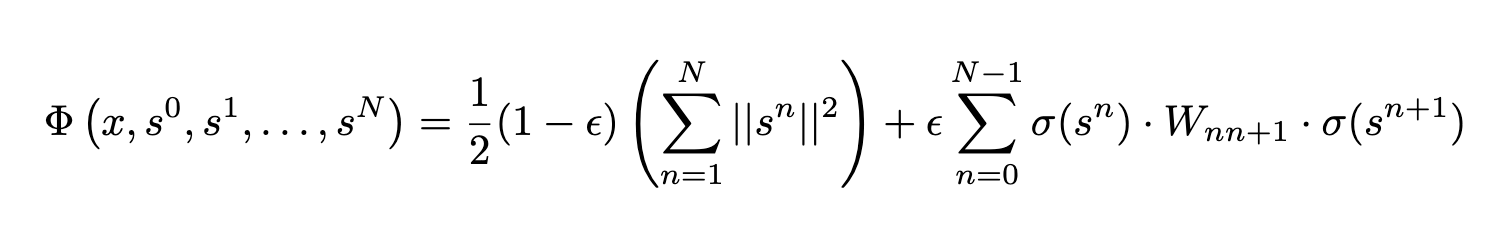

In [139]:
import jax
import jax.numpy as jnp
import optax
from typing import List, Tuple

# Initialize random key
key = jax.random.PRNGKey(42)
num_epochs = 10
batch_size= 1
beta = 0.0000001 
lr = 1
energy_funciton = DeepEnergyConvNetwork(num_inputs=784, num_outputs=10, key=key)
# Fetch and preprocess MNIST dataset
x_train, y_train = fetch_MNIST()  # Assumes this function fetches training data
x_train = jnp.where(x_train > 20, 1, 0)  # Binarize images
x_train = jnp.array(x_train, dtype=jnp.float32)  # Convert to float32

# Create batches
num_samples = x_train.shape[0]
batches: List[Tuple[jnp.ndarray, jnp.ndarray]] = [
    (x_train[i:i + batch_size], y_train[i:i + batch_size])
    for i in range(0, num_samples, batch_size)
]

# Print batch information for verification
print(f"First batch shape (inputs): {batches[0][0].shape}")
print(f"Number of labels in the first batch: {len(batches[0][1])}")


First batch shape (inputs): (1, 1, 28, 28)
Number of labels in the first batch: 1


In [140]:

def step(energy_funciton, beta_state_t, beta_state_t_1):
    layers = []
    def update_weights(p, x):
        path = jax.tree_util.keystr(p).split("[")
        if path[0] == ".layers":
            layer = int(path[1][0])
            calc = (1/beta)*(jnp.outer(jax.nn.tanh(beta_state_t_1[layer]), jax.nn.tanh(beta_state_t_1[layer + 1]).T) - jnp.outer(jax.nn.tanh(beta_state_t[layer]), jax.nn.tanh(beta_state_t[layer + 1]).T)).T
            # print(x.shape)
            # print(calc.shape)

            layers.append(calc)
            return x
        return x

    jax.tree_util.tree_map_with_path(update_weights, energy_funciton)
    return layers
    

# Training loop
for epoch in range(num_epochs): 
    for x, y  in zip(x_train, y_train):
        
        k, key = jax.random.split(key)
        # print(y_train)
        y = jax.nn.one_hot(y_train, 10)
        state = jnp.zeros(shape=(4*784 + 16*784 + 10))
        state = jnp.concat([jnp.reshape(x, (784,)), state])
        for i in range(0, 300):
            state = lr*jax.grad(energy_funciton.primitive)(state)
            # print(state)
            print(energy_funciton.primitive(state))

        beta_state = state
        layers = [0,0,0,0]
        for i in range(0, 40):
            beta_state_t = jnp.split(beta_state, [784, 784 + 4*784, 784 + 4*784+ 16*784])

            def hmm(s):
                s_3 = jnp.split(beta_state, [784 + 4*784+ 16*784])[1]
                return energy_funciton.primitive(s) - beta * jnp.mean((s_3 - y)**2)
            
            beta_state = lr*jax.grad(hmm)(beta_state)

            if i == 0:
                print("-"*30)
            print(energy_funciton.primitive(beta_state))


            beta_state_t_1 = jnp.split(beta_state, [784, 784 + 4*784, 784 + 4*784+ 16*784])
            print(len(step(energy_funciton, beta_state_t, beta_state_t_1)))
            for i, layer in enumerate(step(energy_funciton, beta_state_t, beta_state_t_1)):
                
                layers[i] += layer
               
        def update_weights(p, x):
            path = jax.tree_util.keystr(p).split("[")
            if path[0] == ".layers":
                layer = int(path[1][0])
                return layers[layer]
            return x

        energy_funciton = jax.tree_util.tree_map_with_path(update_weights, energy_funciton)

239.03735
958.7101
3514.6824
8437.326
13791.136
18397.47
22235.814
25497.256
28325.205
30821.025
33055.344
35079.453
36929.906
38635.586
40219.305
41699.395
43090.65
44403.08
45644.55
46822.266
47943.51
49013.09
50036.723
51018.574
51961.71
52870.0
53746.016
54592.11
55410.984
56205.6
56976.58
57724.242
58450.32
59156.39
59843.863
60513.87
61167.25
61804.89
62427.707
63036.79
63632.406
64214.742
64784.27
65341.496
65886.98
66421.234
66944.82
67458.266
67962.06
68456.766
68942.75
69420.34
69889.85
70351.67
70806.414
71254.445
71695.43
72129.32
72556.414
72976.93
73391.13
73799.22
74201.35
74597.75
74988.57
75373.984
75754.14
76129.27
76499.58
76865.37
77226.8
77583.7
77936.28
78284.664
78629.01
78969.37
79305.73
79638.17
79966.87
80291.9
80613.41
80931.47
81246.195
81557.65
81865.84
82170.86
82472.695
82771.375
83067.0
83359.62
83649.32
83936.16
84220.22
84501.56
84780.234
85056.336
85329.91
85601.03
85869.77
86136.234
86400.58
86662.9
86923.21
87181.414
87437.43
87691.234
87942.89
8819

KeyboardInterrupt: 

I think I need to be more simple before building on more complicated problems. Let's start with a super simple one.